In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)

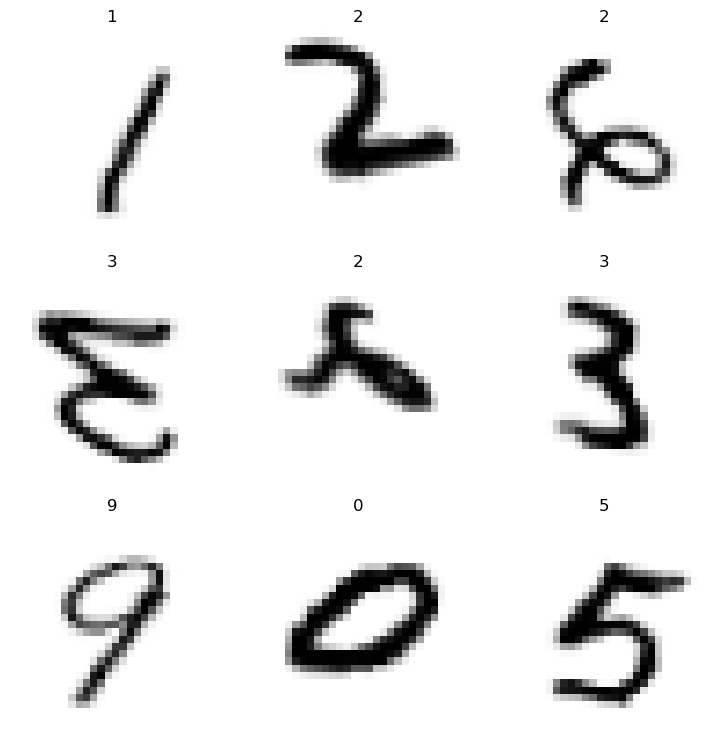

In [ ]:
data = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                get_items=get_image_files,
                get_y=parent_label,
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                item_tfms=Resize(28),
                batch_tfms=aug_transforms())

dls = data.dataloaders((path/"training"))
dls.show_batch()

In [ ]:
xb, yb = first(dls.valid)
xb.shape, yb.shape


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
train_digits_tensors = [torch.stack([tensor(Image.open(digit)).float()/255 for digit in digit_path.ls()]) for digit_path in (path/'training').ls()]
train_x = torch.cat(train_digits_tensors).view(-1, 28*28)
train_y = tensor([i for i, digit in enumerate(train_digits_tensors) for _ in range(len(digit))]).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [ ]:
valid_digits_tensors = [torch.stack([tensor(Image.open(digit)).float()/255 for digit in digit_path.ls()]) for digit_path in (path/'testing').ls()]
valid_x = torch.cat(valid_digits_tensors).view(-1, 28*28)
valid_y = tensor([i for i, digit in enumerate(valid_digits_tensors) for _ in range(len(digit))]).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [ ]:
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))
dl = DataLoader(dset, batch_size=128)
valid_dl = DataLoader(valid_dset, batch_size=128)

In [ ]:
def init_parameters(shape, std=1):
    return tensor(torch.randn(shape)*std).requires_grad_(), tensor(torch.randn(shape[1])*std).requires_grad_()

In [ ]:
def softmax(z, dim=1):
    return z.exp()/z.exp().sum(dim=dim, keepdim=True)
acts = torch.randn((6, 2))*2
pacts = softmax(acts)
acts, pacts

(tensor([[ 0.3142, -2.8707],
         [ 0.6680,  0.6628],
         [ 0.9832, -1.3665],
         [-0.1982, -0.9454],
         [-0.4072, -2.1041],
         [ 1.1284, -0.8852]]),
 tensor([[0.9603, 0.0397],
         [0.5013, 0.4987],
         [0.9129, 0.0871],
         [0.6786, 0.3214],
         [0.8451, 0.1549],
         [0.8822, 0.1178]]))

In [ ]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)


def mnist_loss(preds, target):
    idx = range(len(target))
    return (-torch.log(preds[idx, target])).mean()

def batch_accuracy(preds, trgts):
    preds = softmax(preds)
    res = torch.round(preds[range(len(trgts)), trgts]).mean()
    return res



class BasicOpt:
    def __init__(self, params, lr): self.params, self.lr = params, lr
    def step(self, *args, **kwargs):
        for layer in self.params:
            for p in layer:
                p.data -= p.grad * self.lr
    def zero_grad(self):
        for layer in self.params:
            for p in layer:
                p.grad = None




class Linear:
    def __init__(self, shape, std=1):
        weights, bias = self.param_init(shape, std)

        self.params = weights, bias

    def param_init(self, shape, std=1):
        if len(shape) == 2:
            std = (2.0 / (shape[0] + shape[1]))**0.5
        return tensor(torch.randn(shape)*std).requires_grad_(), tensor(torch.randn(shape[1])*std).requires_grad_()


    def parameters(self):
        return self.params

    def predict(self, X):
        pred = X@self.params[0] + self.params[1]
        return pred

class NonLinearity:
    def __init__(self, act_type='ReLU'):
        self.act_type = act_type.lower()
        self.params = None


    def F(self, xb):
        if self.act_type=='relu':
            return torch.max(tensor(0), xb)
        if self.act_type=='sigmoid':
            return 1/(1+(-xb).exp())
        if self.act_type =='softmax':
            xb = xb.exp()/xb.exp().sum(dim=1, keepdim=True)
            return xb
class Sequential:
    def __init__(self, *args):
        self.layers = args
        self.params = [args[i].params for i in range(len(args)) if args[i].params]

    def predict(self, xb):
        preds = xb
        for layer in self.layers:
            #                    Linear layer        None linearity
            preds = layer.predict(preds) if layer.params else layer.F(preds)
        return preds


class CustomLearner:
    def __init__(self, dls, model, loss_func, opt_func, metrics):
        self.train_dl = dls.train
        self.valid_dl = dls.valid
        self.model = model
        self.loss_ = loss_func
        self.opt_ = opt_func
        self.metrics = metrics

    def fit(self, epochs, lr):
        self.opt = self.opt_(self.model.params, lr)
        print('Epoch        train loss        Train accuracy      Valid accuracy')

        for epoch in range(epochs):
            for xb, yb in self.train_dl:
                preds = self.model.predict(xb)
                yb=yb.squeeze(1)

                loss = self.loss_(preds, yb)
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()

            train_acc, valid_acc = self.validate_apoch()

            print(epoch,"   ", loss.data,"          ", train_acc,"          ", valid_acc)

    def validate_apoch(self):

        valid_acc = [self.metrics(self.model.predict(xb), yb) for xb, yb in self.valid_dl]
        train_acc = [self.metrics(self.model.predict(xb), yb) for xb, yb in self.train_dl]
        va = round(torch.stack(valid_acc).float().mean().item(), 4)
        ta = round(torch.stack(train_acc).float().mean().item(), 4)

        return (ta, va)


simple_net = Sequential(
    Linear((28*28, 200)),
    NonLinearity(),
    Linear((200, 100)),
    NonLinearity(),
    Linear((100, 50)),
    NonLinearity(),
    Linear((50, 20)),
    NonLinearity(),
    Linear((20, 10)),
)
dls = DataLoaders(dl, valid_dl)
learn = CustomLearner(dls=dls, model=simple_net, loss_func=F.cross_entropy, opt_func=BasicOpt, metrics=batch_accuracy)


learn.fit(15, lr=0.005)

Epoch        train loss        Train accuracy      Valid accuracy
0     tensor(0.2593)            0.0995            0.1105
1     tensor(0.0588)            0.0996            0.1109
2     tensor(0.0332)            0.0997            0.1109
3     tensor(0.0268)            0.1204            0.1304
4     tensor(0.0237)            0.1513            0.1573
5     tensor(0.0225)            0.1689            0.1766
6     tensor(0.0223)            0.18            0.1861
7     tensor(0.0207)            0.187            0.1921
8     tensor(0.0187)            0.1891            0.1932
9     tensor(0.0168)            0.1921            0.1943
10     tensor(0.0153)            0.2033            0.202
11     tensor(0.0147)            0.2175            0.2123
12     tensor(0.0149)            0.2335            0.226
13     tensor(0.0153)            0.2488            0.2387
14     tensor(0.0158)            0.2634            0.2521


I trained alot of epochs here.

In [ ]:
learn.fit(30, lr=0.002)

Epoch        train loss        Train accuracy      Valid accuracy
0     tensor(0.0160)            0.8239            0.793
1     tensor(0.0154)            0.8296            0.798
2     tensor(0.0150)            0.8332            0.8004
3     tensor(0.0147)            0.8364            0.8036
4     tensor(0.0145)            0.8388            0.8066
5     tensor(0.0144)            0.8409            0.8089
6     tensor(0.0143)            0.8429            0.8102
7     tensor(0.0142)            0.8449            0.8119
8     tensor(0.0141)            0.8466            0.8135
9     tensor(0.0140)            0.8483            0.8148
10     tensor(0.0140)            0.8497            0.8162
11     tensor(0.0139)            0.8508            0.8178
12     tensor(0.0138)            0.852            0.819
13     tensor(0.0138)            0.8534            0.8211
14     tensor(0.0137)            0.8549            0.8229
15     tensor(0.0136)            0.8561            0.8234
16     tensor(0.0135

final test accuracy of 84% with no Convolutional NNs. so, i guess it's pretty good!